## Toy example

In [1]:
# Imports
import torch
import torch.nn as nn
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [2]:
# Functions
def deterministic_neural_sort(s, tau):
    n = s.size()[1]
    one = torch.ones((n, 1))
    A_s = torch.abs(s - s.permute(0, 2, 1))
    B = torch.matmul(A_s, torch.matmul(one, torch.transpose(one, 0, 1)))
    scaling = (n + 1 - 2 * (torch.arange(n, dtype = torch.float32) + 1))
    C = torch.matmul(s, scaling.unsqueeze(0))
    P_max = (C-B).permute(0, 2, 1)
    sm = torch.nn.Softmax(-1)
    P_hat = sm(P_max/tau)
    return P_hat

def sample_gumbel(samples_shape, eps = 1e-10):
    U = torch.rand(samples_shape)
    return -torch.log(-torch.log(U + eps) + eps)

def stochastic_neural_sort(s, tau):
    batch_size = s.size()[0]
    n = s.size()[1]
    log_s_perturb = torch.log(s) + sample_gumbel([batch_size, n, 1])
    log_s_perturb = log_s_perturb.view(batch_size, n, 1)
    P_hat = deterministic_neural_sort(log_s_perturb, tau)
    P_hat = P_hat.view(batch_size, n, n)
    return P_hat

## Classifier

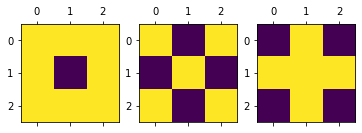

In [3]:
# Creating three base classes for the toy dataset
base1 = np.array([[1., 1., 1.],[1., 0., 1.],[1., 1., 1.]])
base2 = np.array([[1., 0., 1.],[0., 1., 0.],[1., 0., 1.]])
base3 = np.array([[0., 1., 0.],[1., 1., 1.],[0., 1., 0.]])

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.matshow(base1.reshape(3,3)) # Class1
ax2.matshow(base2.reshape(3,3)) # Class2
ax3.matshow(base3.reshape(3,3)) # Class3

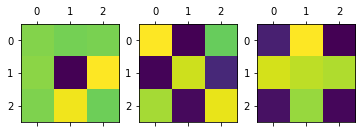

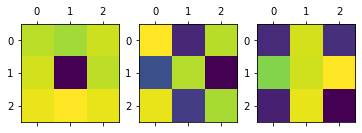

In [4]:
# Creating 100 samples for each class to build the toy dataset
images = np.vstack([i.flatten() + np.random.randn(100,9)*0.1 for i in [base1, base2, base3]])
labels = np.hstack([np.ones(100)*i for i in range(3)])

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.matshow(images[30].reshape(3,3))  # Sample from class1
ax2.matshow(images[130].reshape(3,3)) # Sample from class2
ax3.matshow(images[230].reshape(3,3)) # Sample from class3

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.matshow(images[60].reshape(3,3))  # Sample from class1
ax2.matshow(images[160].reshape(3,3)) # Sample from class2
ax3.matshow(images[260].reshape(3,3)) # Sample from class3

In [5]:
# Classifier model definition
classifier = nn.Sequential(nn.Linear(9,3))
loss_func = nn.CrossEntropyLoss()
opt = torch.optim.Adam(classifier.parameters(), lr=0.04)

In [6]:
# Training (even index elements are chosen as training set) (batch size is 50)
for _ in range(1000):
    rnd_idx = np.random.choice(np.arange(0,300,2), 50, replace=False)
    x = torch.tensor(images[rnd_idx].astype(np.float32))
    y = torch.tensor(labels[rnd_idx].astype(np.int64))
    o = classifier(x)
    loss = loss_func(o, y)
    opt.zero_grad()
    loss.backward()
    opt.step()


In [7]:
# Testing (odd index elements are chosen as testing set)
x = torch.tensor(images[np.arange(1,300,2)].astype(np.float32))
o = classifier(x)
y_hat = np.argmax(o.detach().cpu().numpy(), axis=-1)

print('Testing set accuracy: %.1f%%' % (np.mean(y_hat==labels[np.arange(1,300,2)])*100))

Testing set accuracy: 100.0%


## Neural sorting

In [8]:
.00307911,# Model
score_func = nn.Sequential(nn.Linear(18,1), nn.Sigmoid())
opt = torch.optim.Adam(score_func.parameters(), lr=0.001)

In [9]:
mask_matrix = torch.tensor(np.tril(np.ones((9,9))).astype(np.float32))
print(mask_matrix)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1.]])


In [10]:
mask_tensor = np.zeros((9,9,9))
for i in range(9):
    mask_tensor[i,i,i] = 1
# each of 9, 9x9 matrices, contains only one 1 at the diagonal at position i 
# print(mask_tensor[6])

In [11]:
# Predictions by untrained model
x = images[np.arange(1,300,2)] # Training set [shape: (150, 9)]
x = np.einsum('nd,dij->nij', x, mask_tensor)  # Training set [shape: (150, 9, 9)]  # each sample of the dataset is present in the diagonal
x = torch.tensor(x.astype(np.float32)) # [shape: (150, 9, 9)]
h = torch.cat([x, x.sum(dim=1, keepdim=True).repeat(1,9,1)], dim=-1)   # shape: (150, 9, 18)
s = score_func(h) # shape: (150, 9, 1)
s = s.detach().cpu().numpy()
s_ = s.copy()  

In [12]:
loss_record = []

for train_idx in range(10000):
    rnd_idx = np.random.choice(np.arange(0,300,3), 50, replace=False)

    x = images[rnd_idx]
    x = np.einsum('nd,dij->nij', x, mask_tensor)
    x = torch.tensor(x.astype(np.float32))

    y = torch.tensor(labels[rnd_idx].astype(np.int64)).unsqueeze(1).repeat(1,9).view(-1)

    h = torch.cat([x, x.sum(dim=1, keepdim=True).repeat(1,9,1)], dim=-1)
    s = score_func(h)

    p_relaxed = stochastic_neural_sort(s, 1/(1+train_idx**0.5))

    p_discrete = torch.zeros(50,9,9)
    p_discrete[torch.arange(50).view(-1, 1).repeat(1, 9), torch.arange(9).view(1, -1).repeat(50, 1), torch.argmax(p_relaxed, dim=-1)] = 1

    # permutation matrix
    p = p_relaxed + p_discrete.detach() - p_relaxed.detach() # ST Gradient Estimator
    
    final_mask = torch.matmul(mask_matrix.view(1,9,9), p)

    masked_input = torch.matmul(final_mask, x)

    o = classifier(masked_input)

    loss = loss_func(o.view(-1,3), y)

    loss_eval = loss.detach().cpu().numpy()
    loss_record.append(loss_eval)

    opt.zero_grad()
    loss.backward()
    opt.step()

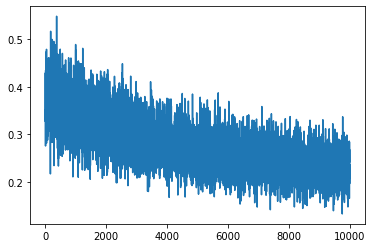

In [13]:
plt.plot(loss_record)


In [17]:
# Testing
x = images[np.arange(1,300,2)]
x = np.einsum('nd,dij->nij', x, mask_tensor)
x = torch.tensor(x.astype(np.float32))

y = torch.tensor(labels[rnd_idx].astype(np.int64)).unsqueeze(1).repeat(1,9).view(-1)

h = torch.cat([x, x.sum(dim=1, keepdim=True).repeat(1,9,1)], dim=-1)
s = score_func(h)

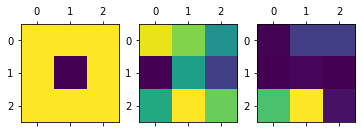

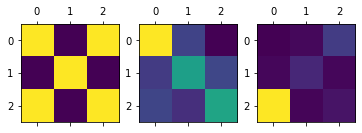

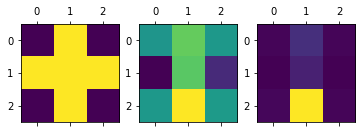

In [18]:
s = s.detach().cpu().numpy()

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.matshow(base1.reshape(3,3))
ax2.matshow(s_[0].reshape(3,3))
ax3.matshow(s[0].reshape(3,3))


fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.matshow(base2.reshape(3,3))
ax2.matshow(s_[50].reshape(3,3))
ax3.matshow(s[50].reshape(3,3))

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.matshow(base3.reshape(3,3))
ax2.matshow(s_[100].reshape(3,3))
ax3.matshow(s[100].reshape(3,3))